In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import seaborn as sns
from scipy.stats import kstest
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

In [2]:
marks = pd.read_csv('Student_Marks.csv')
marks['Marks'] /= 55.3
marks

,number_courses,time_study,Marks
0,3,4.508,0.347233
1,4,0.096,0.139855
2,4,3.133,0.249747
3,6,7.909,0.958734
4,8,7.811,0.999982
...,...,...,...
95,6,3.561,0.345895
96,3,0.301,0.101429
97,4,7.163,0.749439
98,7,0.309,0.217486


In [3]:
y, X = dmatrices('Marks ~ number_courses + time_study', data=marks, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor        features
0   11.042137       Intercept
1    1.043799  number_courses
2    1.043799      time_study


In [4]:
model = smf.ols('Marks ~ time_study',data=marks).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Marks   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     775.8
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           2.36e-48
Time:                        12:07:43   Log-Likelihood:                 103.07
No. Observations:                 100   AIC:                            -202.1
Df Residuals:                      98   BIC:                            -196.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0221      0.017      1.272      0.206      -0.012       0.057
time_study     0.1029      0.004     27.853      0.000       0.096       0.110
==============================================================================
Omnibus:                        7.504   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                4.633
Skew:                           0.357   Prob(JB):                       0.0986
Kurtosis:                       2.225   Cond. No.                         9.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

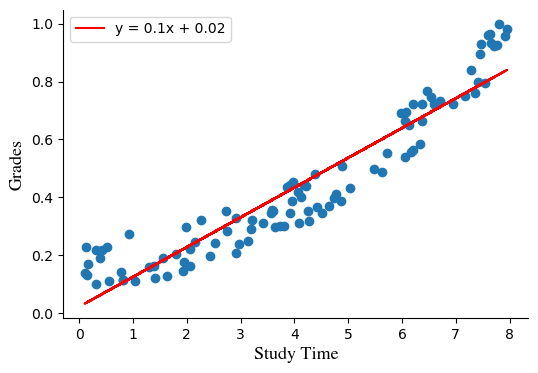

In [5]:
fig, ax = plt.subplots(figsize=(6,4))

x = marks['time_study']
y = marks['Marks']

slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * np.array(x) + intercept, color='red', label=f'y = {round(slope, 2)}x + {round(intercept, 2)}')

ax.scatter(x, y)

ax.set_xlabel("Study Time",fontsize=13, fontname="Times")
ax.set_ylabel("Grades",fontsize=13, fontname="Times")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()

plt.show()

In [6]:
model = smf.ols('Marks ~ number_courses + time_study',data=marks).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Marks   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     764.8
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           4.09e-60
Time:                        12:07:43   Log-Likelihood:                 134.65
No. Observations:                 100   AIC:                            -263.3
Df Residuals:                      97   BIC:                            -255.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1348      0.021     -6.349      0.000      -0.177      -0.093
number_courses     0.0337      0.004      9.243      0.000       0.026       0.041
time_study         0.0976      0.003     35.303      0.000       0.092       0.103
==============================================================================
Omnibus:                       29.529   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.956
Skew:                           0.526   Prob(JB):                      0.00689
Kurtosis:                       1.867   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

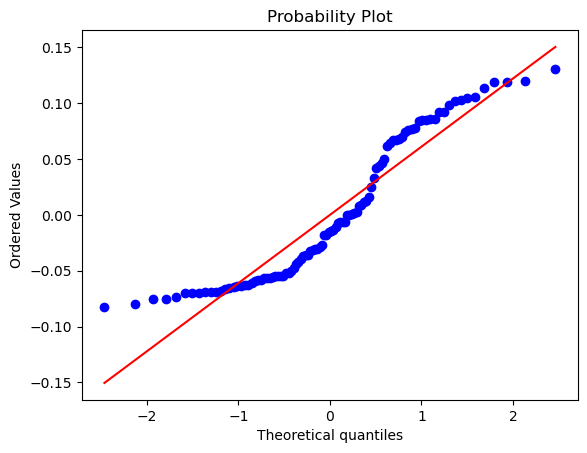

In [7]:
stats.probplot(model.resid, plot=plt)
plt.show()

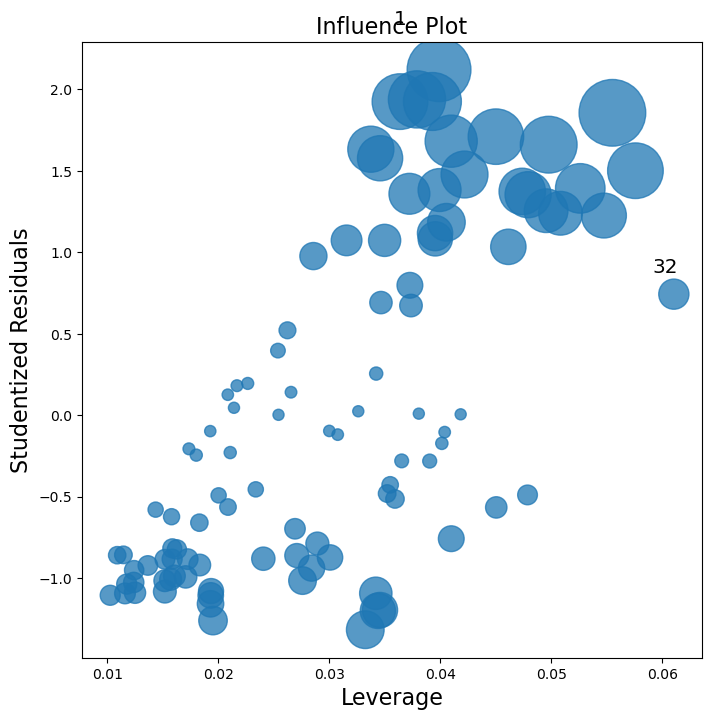

In [8]:
infl = model.get_influence()

#Breusch-Pagan for Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']

#external t
n=len(marks)
p=5
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud

#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n

studentized = marks.index[atyp_stud]

cooks = marks.index[atyp_cook]

def convert_to_binary(input_array):
    # Dictionary to map "yes" to 1 and "no" to 0
    conversion_dict = {"yes": 1, "no": 0}
    # Using list comprehension to convert array elements to binary
    binary_array = [conversion_dict[element] for element in input_array]
    return binary_array

ones = np.ones(len(marks))
x1 = marks['number_courses']
x2 = marks['time_study']
x = np.column_stack((ones, x1, x2))
h = x @ np.linalg.inv(x.T @ x) @ x.T
def find_high_leverage_pts(matrix, p, n):
    positions = []
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value > 2*p/n:
                positions.append((i, j))
    return positions

# Find positions of values greater than 10 in the matrix
positions = find_high_leverage_pts(h, 5, 1338)

hii = set()
for i in positions:
    hii.add(i[0])

studentized_cooks = list(set(studentized).intersection(set(cooks)))
outliers = list(set(studentized_cooks).intersection(hii))

fig, ax = plt.subplots(figsize=(8,8))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [9]:
n=len(marks)
p=3
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#which ones?
print(marks.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([1], dtype='int64') [2.12084831]


In [10]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n

cooks = marks.index[atyp_cook]
cooks

Int64Index([1, 3, 4, 28, 35, 40, 64, 96], dtype='int64')

In [11]:
outliers = list(set(studentized).union(set(cooks)))
outliers

[64, 1, 96, 3, 4, 35, 40, 28]

In [12]:
marks_clean = marks.drop(outliers)

In [13]:
model_clean = smf.ols('Marks ~ number_courses + time_study', data = marks_clean).fit()
model_clean

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

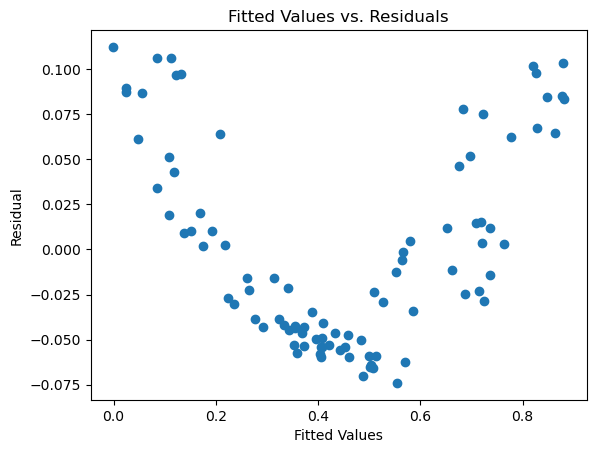

In [14]:
p = model_clean.fittedvalues
res = model_clean.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [15]:
model_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Marks   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     829.5
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           2.85e-58
Time:                        12:07:44   Log-Likelihood:                 135.86
No. Observations:                  92   AIC:                            -265.7
Df Residuals:                      89   BIC:                            -258.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1577      0.020     -7.883      0.000      -0.197      -0.118
number_courses     0.0340      0.003     10.223      0.000       0.027       0.041
time_study         0.1004      0.003     36.780      0.000       0.095       0.106
==============================================================================
Omnibus:                       17.237   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.498
Skew:                           0.616   Prob(JB):                      0.00866
Kurtosis:                       2.021   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

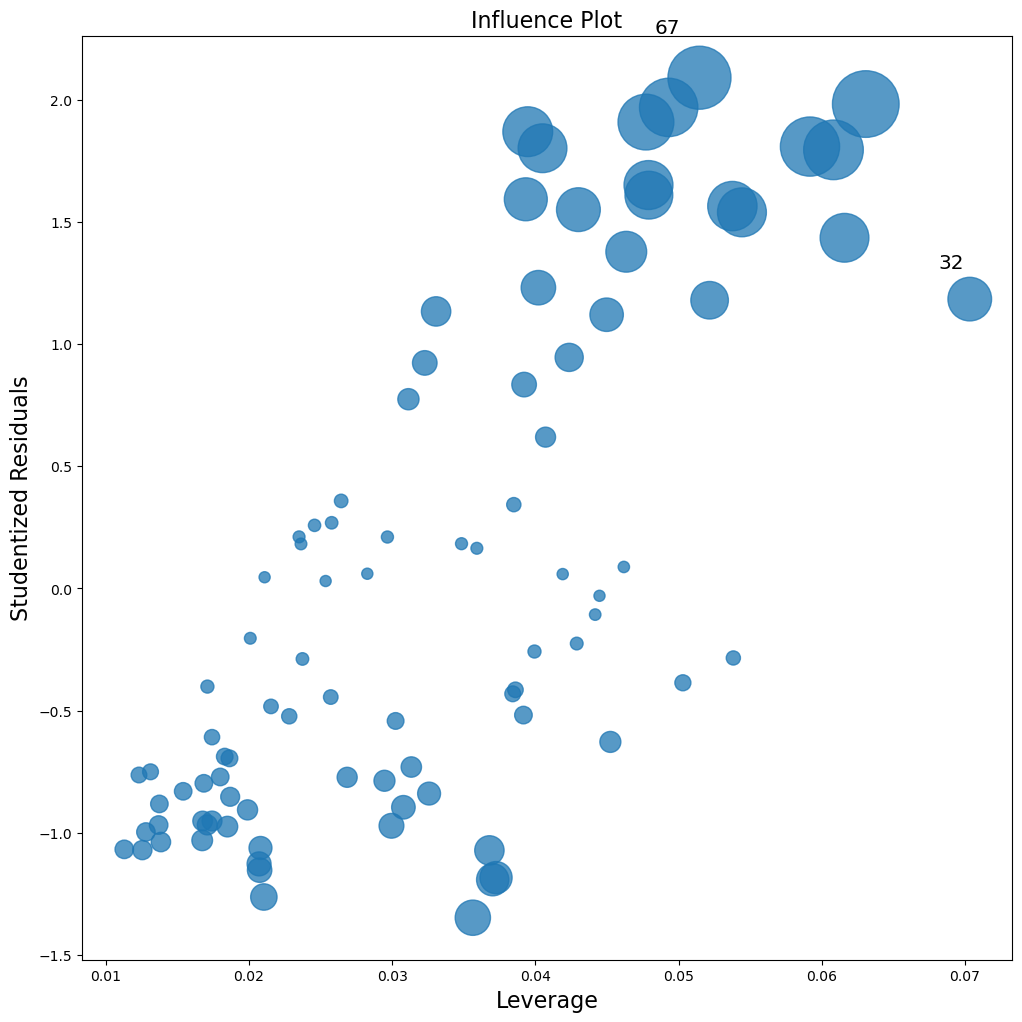

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model_clean,ax=ax, criterion="cooks") 

In [17]:
bp_test = het_breuschpagan(model_clean.resid, model_clean.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 4.015689075894024, 'LM-Test p-value': 0.1342777936531459}


KstestResult(statistic=0.4704861650367011, pvalue=3.337161465128628e-19, statistic_location=-0.07404782595890053, statistic_sign=-1)


(array([13., 21., 11.,  7., 13.,  2.,  4.,  5.,  8.,  8.]),
 array([-0.07404783, -0.0554099 , -0.03677196, -0.01813403,  0.0005039 ,
         0.01914183,  0.03777976,  0.05641769,  0.07505562,  0.09369355,
         0.11233148]),
 <BarContainer object of 10 artists>)

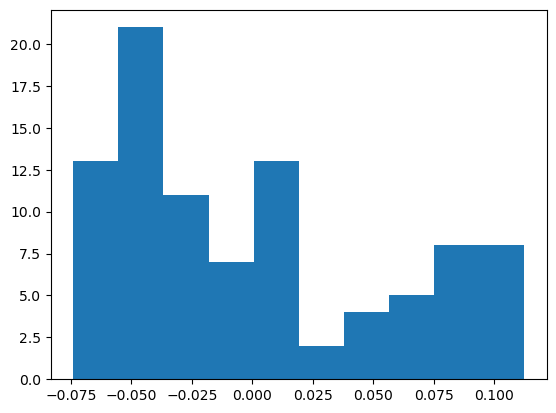

In [18]:
print(kstest(model_clean.resid,'norm'))
plt.hist(model_clean.resid)

In [19]:
marks['ln_marks'] = np.log(marks['Marks'])
model_clean_ln = smf.ols('ln_marks ~ number_courses + time_study', data=marks).fit()

KstestResult(statistic=0.40317736484868405, pvalue=3.4190904740666387e-15, statistic_location=0.2193791251518551, statistic_sign=1)


(array([ 3.,  4.,  9., 11., 35., 17., 10.,  6.,  4.,  1.]),
 array([-0.27003481, -0.21251062, -0.15498642, -0.09746222, -0.03993803,
         0.01758617,  0.07511037,  0.13263456,  0.19015876,  0.24768296,
         0.30520715]),
 <BarContainer object of 10 artists>)

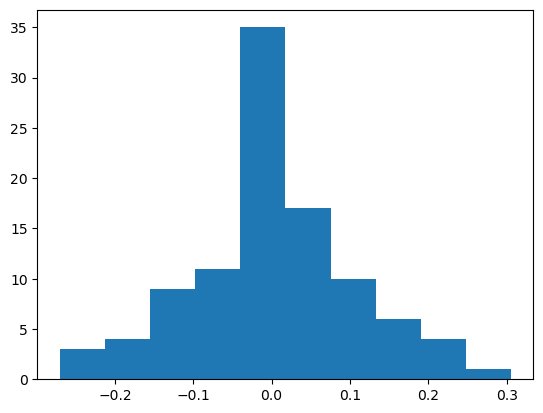

In [20]:
print(kstest(model_clean_ln.resid,'norm'))
plt.hist(model_clean_ln.resid)

In [21]:
model_clean_ln.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_marks   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1659.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           9.69e-76
Time:                        12:07:44   Log-Likelihood:                 82.552
No. Observations:                 100   AIC:                            -159.1
Df Residuals:                      97   BIC:                            -151.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.4685      0.036    -69.031      0.000      -2.539      -2.398
number_courses     0.0932      0.006     15.179      0.000       0.081       0.105
time_study         0.2388      0.005     51.282      0.000       0.230       0.248
==============================================================================
Omnibus:                        1.539   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.039
Skew:                          -0.018   Prob(JB):                        0.595
Kurtosis:                       3.498   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
sm.stats.anova_lm(model_clean_ln, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
number_courses,1.0,7.973671,7.973671,688.561296,7.544546e-46
time_study,1.0,30.454059,30.454059,2629.840948,4.406227e-72
Residual,97.0,1.123278,0.011580,NaN,NaN


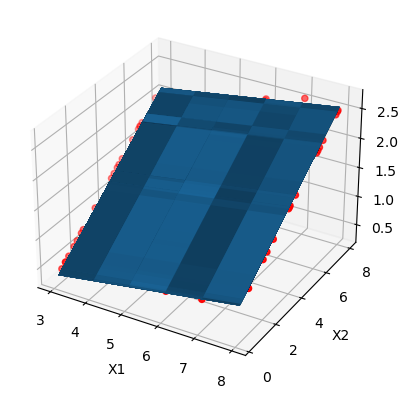

In [23]:
np.random.seed(0)
X1 = marks_clean['number_courses']
X2 = marks_clean['time_study']
Y = 0.0932 * X1 + 0.2388 * X2 

model = LinearRegression()
X = np.column_stack((X1, X2))
model.fit(X, Y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='r', marker='o')

x1, x2 = np.meshgrid(X1, X2)
y_pred = model.predict(np.column_stack((x1.ravel(), x2.ravel())))
y_pred = y_pred.reshape(x1.shape)

ax.plot_surface(x1, x2, y_pred, alpha=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()